In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib.parallel import Parallel, delayed

In [2]:
def bootstrap(data, agg=np.mean, n_bootstraps=10000, seed=None, ci_width=0.95):
    data = np.asarray(data)
    rng = np.random.RandomState(seed)
    n_samples = len(data)
    all_aggs = []
    for i in range(n_bootstraps):
        idx = rng.random_integers(low=0, high=n_samples - 1, size=n_samples)
        all_aggs.append(agg(data[idx]))
    boostrapped = np.asarray(all_aggs)
    boostrapped.sort()
    
    ci_min = (1 - ci_width) / 2.
    ci_max = 1. - ci_min
    ci = boostrapped[int(ci_min * n_bootstraps)], boostrapped[int(ci_max * n_bootstraps)]
    return boostrapped, ci

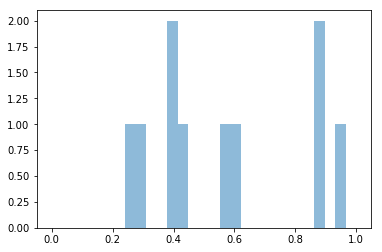

In [3]:
bins = np.linspace(0, 1, 30)
data = np.random.uniform(0, 1, size=10)
_ = plt.hist(data, bins=bins, alpha=0.5)

In [4]:
data.mean()

0.56562987792949193

/Users/thanhbinhle/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead


(0.38620096068807508, 0.76669642886593503)

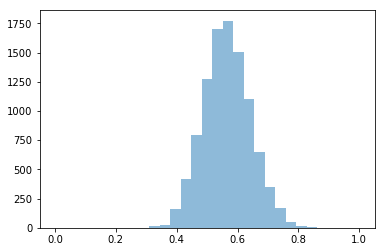

In [5]:
bootstrapped, ci = bootstrap(data, ci_width=0.99)
_ = plt.hist(bootstrapped, bins=bins, alpha=0.5)
ci

In [6]:
def unbiased_std(x):
    return np.std(x, ddof=1)

/Users/thanhbinhle/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead


(0.10312460806243789, 0.31748546048767617)

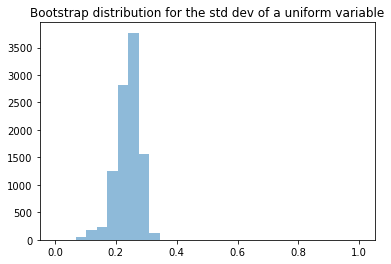

In [7]:
bootstrapped, ci = bootstrap(data, agg=unbiased_std, ci_width=0.99)
_ = plt.hist(bootstrapped, bins=bins, alpha=0.5)
plt.title("Bootstrap distribution for the std dev of a uniform variable")
ci

## Evaluation of the correctness of the bootstrap CI for the mean of a uniform variable

In [8]:
%%time

target_ci_width = 0.95


def compute_ci_correctness(n_samples, true_value, agg=np.mean, target_ci_width=0.95,
                           n_runs = 100):
    correctness = []
    for i in range(n_runs):
        data = np.random.uniform(0, 1, size=n_samples)
        _, ci = bootstrap(data, agg=agg, ci_width=target_ci_width,
                          n_bootstraps=5000)
        correctness.append(float(ci[0] <= true_value <= ci[1]))
        
    # Look Ma': boostrap CI on the boostrap CI correctness
    _, ci_outcomes = bootstrap(correctness, ci_width=0.99,
                               n_bootstraps=10000)
    return {
        'n_samples': n_samples,
        'correctness': np.mean(correctness),
        'ci_0025_correct': ci_outcomes[0],
        'ci_0975_correct': ci_outcomes[1],
    }
    

all_outcomes = Parallel(n_jobs=-1)(delayed(compute_ci_correctness)(
    n_samples, 0.5, agg=np.mean, target_ci_width=target_ci_width)
    for n_samples in [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    
all_outcomes = pd.DataFrame(all_outcomes)

/Users/thanhbinhle/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 4 + 1) instead
/Users/thanhbinhle/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
/Users/thanhbinhle/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
/Users/thanhbinhle/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 19 + 1) instead
/Users/thanhbinhle/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 99 + 1) instead
/Users/thanhbinhle/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 99 + 

CPU times: user 121 ms, sys: 46.7 ms, total: 168 ms
Wall time: 59.4 s


In [ ]:
def plot_outcomes(all_outcomes, target_ci_width):
    plt.fill_between(all_outcomes.n_samples.values,
                     all_outcomes.ci_0025_correct.values,
                     all_outcomes.ci_0975_correct.values,
                     alpha=0.2, color='b')
    plt.plot(all_outcomes.n_samples, all_outcomes.correctness, 'o-',
             alpha=0.8, color='b')
    
    plt.hlines(target_ci_width,
               all_outcomes.n_samples.min(), all_outcomes.n_samples.max(),
               linestyles='dotted')
    plt.ylim(0.5, 1)
    plt.title("Correctness of the bootstrap CI interval")
    plt.xlabel("Number of source samples")
    plt.ylabel("Rate of true value belonging to the CI interval")
    
plot_outcomes(all_outcomes, target_ci_width)
all_outcomes

,ci_0025_correct,ci_0975_correct,correctness,n_samples
0,0.59,0.82,0.71,3
1,0.81,0.97,0.90,5
2,0.83,0.97,0.91,10
3,0.84,0.98,0.92,20
4,0.83,0.98,0.91,30
5,0.79,0.96,0.88,40
6,0.86,0.99,0.93,50
7,0.85,0.99,0.93,60
8,0.82,0.97,0.90,70
9,0.89,1.00,0.95,80


## Evaluation of the correctness of the bootstrap CI for the std deviation of a uniform variable

In [19]:
all_outcomes = Parallel(n_jobs=-1)(delayed(compute_ci_correctness)(
    n_samples, 1 / np.sqrt(12), target_ci_width=target_ci_width, agg=unbiased_std)
    for n_samples in [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    
all_outcomes = pd.DataFrame(all_outcomes)

,ci_0025_correct,ci_0975_correct,correctness,n_samples
0,0.24,0.49,0.36,3
1,0.50,0.75,0.63,5
2,0.80,0.96,0.89,10
3,0.82,0.97,0.90,20
4,0.84,0.98,0.92,30
5,0.87,0.99,0.94,40
6,0.87,0.99,0.94,50
7,0.83,0.97,0.91,60
8,0.89,1.00,0.95,70
9,0.92,1.00,0.97,80


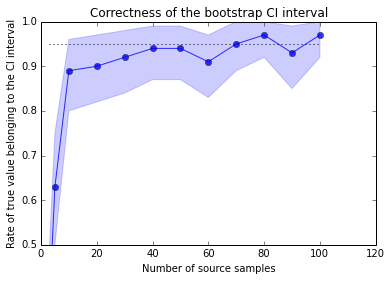

In [20]:
plot_outcomes(all_outcomes, target_ci_width)
all_outcomes